### 테스트 데이터셋 만들기
 - 이전에는 각 분류기를 학습하는 것이기 때문에, 0,1로 레이블을 변경해주었다.
 - 하지만, 직렬로 연결하고 나서는 0,1,2,3,4로 레이블을 변경해야 한다.
  - 훈련하는게 아니므로 train, val은 생략.

Labels
0    963
2    544
1    283
4    245
3    117
Name: count, dtype: int64

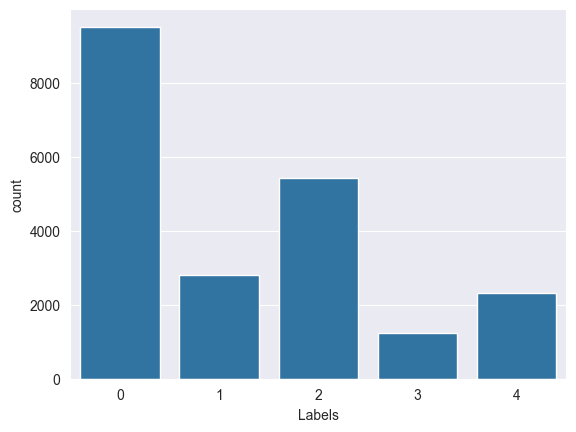

In [1]:
from torch.utils.data import DataLoader
from ver4_journal.common.data.ECG_Data import ECG_Data
from ver4_journal.common.data.create_final_data import create_final_data

final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)
ECG_test = ECG_test[ECG_test['Labels'].isin([0,1,2,3,4])].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)

ECG_test['Labels'].value_counts()

### 현재 모델의 0~4번 순서는 데이터셋의 양에 따라 정해진게 아니다
-  `NORM - STTC - MI - HYP - CD`로 임의로 돼있다.
-  이를 `NORM - MI - STTC - CD - HYP`로 순서를 바꿔야 한다.

In [3]:
from ver4_journal.common.network.BCResNets import BCResNets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 순서 정의
sequence = [0, 2, 1, 4, 3]
num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'../common/best_models/{dd}model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

# 임계값을 0.05씩 증가시키며 테스트
thresholds = np.arange(0.50, 1.00, 0.05)

for threshold in thresholds:
    print("=====================================================================")
    print(f'\nTesting Serialized Model Pipeline with Threshold: {threshold:.2f}')
    y_true = []
    y_pred = []

    # 테스트 데이터셋을 연결된 모델에 사용
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)

            # 각 데이터 포인트별로 클래스 레이블을 결정
            for i in range(data.size(0)):  # 배치 내 각 샘플에 대해 반복
                sample = data[i].unsqueeze(0)  # 샘플 하나를 추출
                class_label = None

                # 모든 모델을 순차적으로 거치며, 특정 클래스에 속하는지 확인
                for idx, model in enumerate(best_models):
                    output = model(sample)
                    output = torch.sigmoid(output).item()  # 각 모델의 출력을 sigmoid로 변환하고 스칼라로 변환

                    # 임계값을 넘는 첫 번째 클래스를 찾아 레이블로 지정
                    if output > threshold:
                        class_label = sequence[idx]
                        break

                # 만약 모든 모델의 출력이 임계값 이하라면, OTHER 클래스로 설정
                if class_label is None:
                    class_label = 100  # OTHER 클래스는(100)

                # 최종 클래스 레이블 저장
                y_true.append(label[i].item())  # 샘플의 label 저장
                y_pred.append(class_label)  # 해당 샘플의 예측된 클래스 레이블 저장

    # Confusion Matrix 계산 및 시각화
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 100])
    print(f'임계값: {thresholds}')
    print(f'Confusion Matrix:\n{conf_matrix}')
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'], 
                yticklabels=['NORM', 'STTC', 'MI', 'HYP', 'CD', 'OTHER'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for Serialized Model (Threshold: {threshold:.2f})')
    plt.show()
    """
    # Classification Report 추가 (OTHER 클래스 제외)
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['NORM', 'STTC', 'MI', 'HYP', 'CD'], labels=[0, 1, 2, 3, 4], zero_division=0))
    print("=====================================================================")
    


Testing Serialized Model Pipeline with Threshold: 0.50
임계값: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Confusion Matrix:
[[865   0   8   0   2  88]
 [ 40   4  16   7   2 214]
 [ 82   1 309   4   8 140]
 [ 33   2   9  22   4  47]
 [ 48   0  31   1  86  79]
 [  0   0   0   0   0   0]]

Classification Report:
              precision    recall  f1-score   support

        NORM       0.81      0.90      0.85       963
        STTC       0.57      0.01      0.03       283
          MI       0.83      0.57      0.67       544
         HYP       0.65      0.19      0.29       117
          CD       0.84      0.35      0.50       245

   micro avg       0.81      0.60      0.69      2152
   macro avg       0.74      0.40      0.47      2152
weighted avg       0.78      0.60      0.63      2152


Testing Serialized Model Pipeline with Threshold: 0.55
임계값: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Confusion Matrix:
[[843   0   4   0   2 114]
 [ 32   0  11   6   1 233]
 [ 64   